In [1]:
import numpy as np
from os.path import dirname, abspath, join as pjoin
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.mocks import *
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import glob, time 

from astropy.io import fits as fits
from astropy.table import Table, vstack
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.targets import desi_mask, bgs_mask, mws_mask 
from desitarget.geomask import get_imaging_maskbits 

In [2]:
#https://arxiv.org/pdf/2106.13120.pdf

to_grab=glob.glob('/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/targets-bright-hp-*.fits') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

#do timer as takes a while
start = time.time() 

#total number of pixels, not quite sure where this has come from as npix is less than this above 


mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

#loop through pixels
for i, x in enumerate(to_grab):
    x = fits.open(x)
    f = np.array(x[1].data)[['RA','DEC','TARGETID', 'BGS_TARGET', 'MWS_TARGET','PHOTSYS']]
    #mask for bgs objects
    
    is_bgs = (f[mmask] & bgs_mask[ttype]) != 0
    #idx = np.arange(len(x))[is_bgs]
    #x = x.iloc[idx] 
    hp_stack.append(f[is_bgs])

    #more timing stuff
    if (i % 20) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    

data_stack = np.concatenate(hp_stack)      
        

data_stack = Table(data_stack)






data_stack

Runtime of 0.291577 seconds after 0 pixels
Runtime of 9.867510 seconds after 20 pixels
Runtime of 17.766986 seconds after 40 pixels
Runtime of 26.552448 seconds after 60 pixels
Runtime of 34.235955 seconds after 80 pixels
Runtime of 43.452795 seconds after 100 pixels
Runtime of 57.949470 seconds after 120 pixels
Runtime of 67.470304 seconds after 140 pixels
Runtime of 79.664254 seconds after 160 pixels
Runtime of 93.909572 seconds after 180 pixels
Runtime of 107.954173 seconds after 200 pixels
Runtime of 119.200478 seconds after 220 pixels
Runtime of 126.387088 seconds after 240 pixels
Runtime of 138.861286 seconds after 260 pixels
Runtime of 151.362500 seconds after 280 pixels
Runtime of 171.554987 seconds after 300 pixels
Runtime of 186.662994 seconds after 320 pixels
Runtime of 201.223251 seconds after 340 pixels
Runtime of 213.372132 seconds after 360 pixels
Runtime of 222.592223 seconds after 380 pixels
Runtime of 233.309531 seconds after 400 pixels
Runtime of 252.006986 seconds a

RA,DEC,TARGETID,BGS_TARGET,MWS_TARGET,PHOTSYS
float64,float64,int64,int64,int64,bytes1
39.87345241480437,4.665933584901227,39627900093202905,131074,0,S
39.877053486508814,4.711238350826682,39627900093203017,131074,0,S
39.87915609182511,4.770786080678859,39627900093203092,131074,0,S
39.8820675774046,4.81261018424266,39627900093203195,131074,0,S
39.8906900429301,4.853959519139267,39627900093203471,131074,0,S
39.89212755501432,4.831044142844941,39627900093203516,131074,0,S
39.89672633565589,4.833354165330929,39627900093203673,131074,0,S
39.90121357739571,4.672729345915309,39627900093203812,131074,0,S
39.90993597426195,4.638922607666945,39627900093204074,131074,0,S


In [3]:
#select DECALS
data_stack = data_stack[(data_stack['PHOTSYS']=='S')]

In [ ]:
#angular correlation function for mock data.  
#https://corrfunc.readthedocs.io/en/master/modules/converting_ddtheta_mocks.html?highlight=wtheta


import numpy as np
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf


# Read the supplied galaxies on a periodic box
#f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.9.fits')
#mxxl=f[1].data

data_stack_small = data_stack[((data_stack['RA']>150) & (data_stack['RA']<210) & (data_stack['DEC']>0) & (data_stack['DEC']<30))]

RA = data_stack_small['RA']
DEC = data_stack_small['DEC']
N = len(RA)

# Read the supplied randoms catalog
f = fits.open('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits')
random1=f[1].data

random1_small = random1[((random1['RA']>150) & (random1['RA']<210) & (random1['DEC']>0) & (random1['DEC']<30))]

rand_RA = random1_small['RA']
rand_DEC = random1_small['DEC']
rand_N = len(rand_RA)

# Setup the bins
nbins = 30
bins = np.logspace(-3, 1, nbins + 1, base=10)
#bins = np.linspace(0.001, 10.0, nbins + 1)

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)

# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)

# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

# All the pair counts are done, get the angular correlation function
wtheta = convert_3d_counts_to_cf(N, N, rand_N, rand_N, DD_counts, DR_counts,DR_counts, RR_counts)

/global/homes/l/lbigwood/.local/lib/python3.8/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


In [ ]:
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)


bins = np.logspace(-3, 1, nbins + 1, base=10)
x_axis = []
for i in range(len(bins)-1):
    x_axis.append((bins[i]+bins[i+1])/2)

y_axis = []
for i in range(len(x_axis)):
    y_axis.append(wtheta[i]*x_axis[i]**(1.8-1))
    
plt.figure(figsize=(12,10))
plt.plot(x_axis, y_axis,color='#1e3799')
plt.xlabel(r'$\theta$ / deg')
plt.ylabel(r'$\omega (\theta)\times \theta^{-(1-\gamma)}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,5e-2)
#plt.savefig('corrfunc_1800.png',bbox_inches='tight')



#add max seperation 

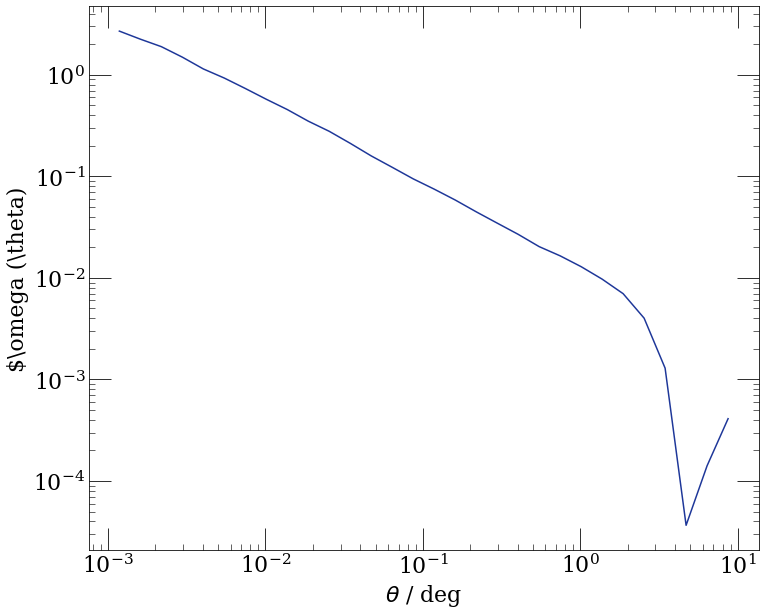

In [25]:
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)


bins = np.logspace(-3, 1, nbins + 1, base=10)
x_axis = []
for i in range(len(bins)-1):
    x_axis.append((bins[i]+bins[i+1])/2)

y_axis = []
for i in range(len(x_axis)):
    y_axis.append(wtheta[i])
    
plt.figure(figsize=(12,10))
plt.plot(x_axis, y_axis,color='#1e3799')
plt.xlabel(r'$\theta$ / deg')
plt.ylabel(r'$\omega (\theta)')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-4,5e-2)
#plt.savefig('corrfunc.png',bbox_inches='tight')

In [ ]:
plt.rc('xtick',direction='in',labelsize=22,top=True)
plt.rc('ytick',direction='in',labelsize=22, right = True)
plt.rc('xtick.major',size = 22)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 22)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 22)
plt.rc('legend',fontsize=22)
plt.rc('font', family='serif',size=20)


bins = np.logspace(-3, 1, nbins + 1, base=10)
x_axis = []
for i in range(len(bins)-1):
    x_axis.append((bins[i]+bins[i+1])/2)

y_axis = []
for i in range(len(x_axis)):
    y_axis.append(wtheta[i])
    
plt.figure(figsize=(12,10))
plt.plot(x_axis, y_axis,color='#1e3799')
plt.xlabel(r'$\theta$ / deg')
plt.ylabel(r'$\omega (\theta)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3,10)
#plt.savefig('corrfunc.png',bbox_inches='tight')